In [1]:
# !pip install odfpy
# !pip install seaborn
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu
import networkx as nx
import matplotlib.pyplot as plt

In [21]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group_bigstitcher = 'WILD_bigstitcher'
data_directory_bigstitcher = root_directory + experiment + '/' \
                + experimental_group_bigstitcher + '/'
subjects_bigstitcher = [name for name in os.listdir(data_directory_bigstitcher) \
            if os.path.isdir(os.path.join(data_directory_bigstitcher, name))]

experimental_group_terastitcher = 'WILD_terastitcher'
data_directory_terastitcher = root_directory + experiment + '/' \
                + experimental_group_terastitcher + '/'
subjects_terastitcher = [name for name in os.listdir(data_directory_terastitcher) \
            if os.path.isdir(os.path.join(data_directory_terastitcher, name))]

In [22]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

In [23]:
def load_subject(subject, data_directory, threshold):
    file_suffix = 'cells' + str(threshold)
    df_mouse = pd.read_csv(data_directory + subject + '/' + file_suffix + '.csv')
    df_mouse = ace.reformat_df_mouse(df=df_mouse)
    
    return df_mouse

In [24]:
def print_results(experimental_groups, groups_df, area=None):
    for i, df in zip(experimental_groups.keys(), groups_df):
        print(i)
        if area==None:
            print(df.set_index('area').sum().to_string())
        else:
            print(df.set_index('area').loc[area].to_string())
        print(' ')

In [28]:
dict_results_across_mice = {
    stitcher:{
    subject: ace.calculate_cells_energy_per_level(
    df_mouse=load_subject(subject=subject, 
                          data_directory=data_directory,
                          threshold=2500),
    vol=volumes,
    level=8) for subject in [name for name in os.listdir(data_directory) \
            if os.path.isdir(os.path.join(data_directory, name))]
    } for stitcher, data_directory in zip(['terastitcher', 'bigstitcher'],
                                          [data_directory_terastitcher, data_directory_bigstitcher])}
np.save('dict_results/dict_results_across_mice_cfr_stitcher.npy', dict_results_across_mice)

<ipython-input-28-3fbf8813dcf9>:1: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  dict_results_across_mice = {


In [185]:
def make_df(dictionary, area=None, unstack=False):
    data = dictionary
    # Flatten the nested dictionary and create a DataFrame 
    if area==None:
            df = pd.DataFrame.from_dict({(level1, level2, level3): value.sum()
                                for level1, inner_dict in data.items() 
                                for level2, inner_inner_dict in inner_dict.items() 
                                for level3, value in inner_inner_dict.items() if level3!='area'}, 
                                orient='index')
    else:
        df = pd.DataFrame.from_dict({(level1, level2, level3): value
                                    for level1, inner_dict in data.items() 
                                    for level2, inner_inner_dict in inner_dict.items() 
                                    for level3, value in inner_inner_dict.set_index('area').loc[area].items() if level3!='area'}, 
                                    orient='index')      
    # Set MultiIndex 
    df.index = pd.MultiIndex.from_tuples(df.index) 
    # Unstack and obtain terastitcher and bigstitcher as columns
    if unstack:
        df = df.unstack(level=0)
        df.columns = df.columns.droplevel(0)
    else:
        # Reset the index to use MultiIndex as columns
        df.reset_index(inplace=True)
        # Rename the columns
        df.columns = ['Stitcher', 'Subject', 'Measure', 'Value']
    return df


In [186]:
def plot_differences(df):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    measures = df['Measure'].unique()

    for ax, measure in zip(axs.flatten(), measures):
        # Filter data for each measure
        data_measure = df[df['Measure'] == measure]

        # Create barplot
        sns.barplot(x='Subject', y='Value', hue='Stitcher', data=data_measure, ax=ax)

        # Set title
        ax.set_title(measure)

    # Adjust layout
    plt.tight_layout()
    plt.show()

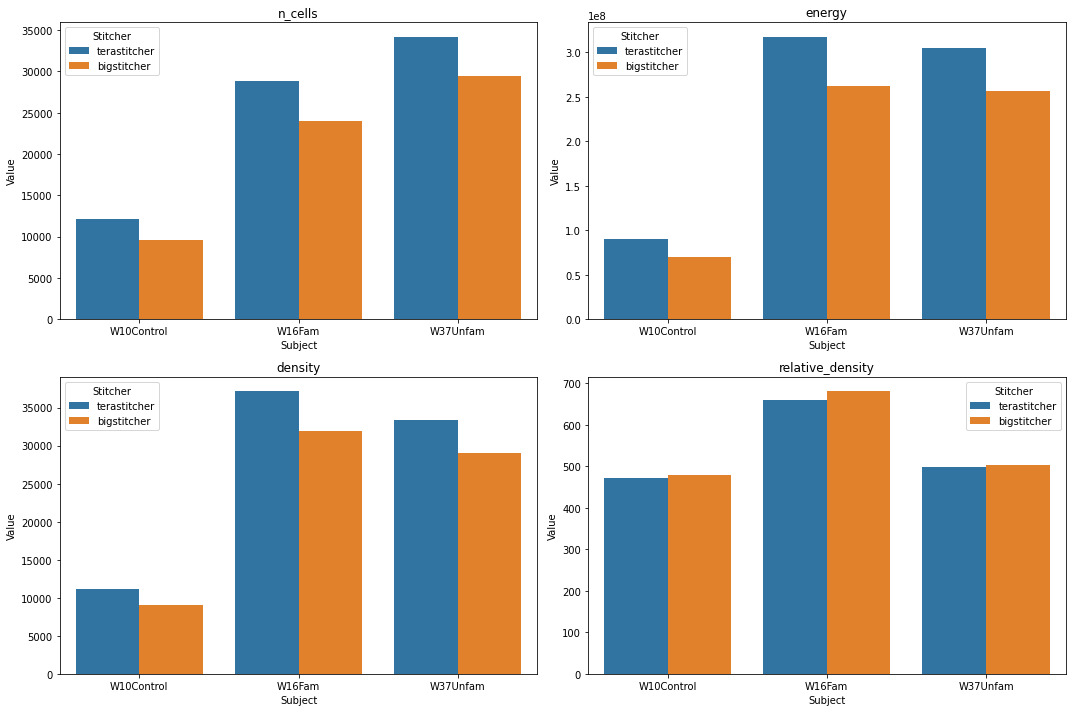

In [187]:
plot_differences(df=make_df(dictionary=dict_results_across_mice, area=None))

In [188]:
make_df(dictionary=dict_results_across_mice, area=None, unstack=True)

bigstitcher  terastitcher
W10Control density           8.984306e+03  1.118824e+04
           energy            6.947386e+07  9.049014e+07
           n_cells           9.588000e+03  1.212800e+04
           relative_density  4.790992e+02  4.716738e+02
W16Fam     density           3.195563e+04  3.717501e+04
           energy            2.625331e+08  3.178990e+08
           n_cells           2.399200e+04  2.880700e+04
           relative_density  6.810043e+02  6.598148e+02
W37Unfam   density           2.906845e+04  3.338703e+04
           energy            2.569197e+08  3.052769e+08
           n_cells           2.949100e+04  3.422300e+04
           relative_density  5.039660e+02  4.988026e+02

In [140]:
dict_results_across_mice['terastitcher'].keys()

dict_keys(['W10Control', 'W16Fam', 'W37Unfam'])

In [141]:
dict_results_across_mice['terastitcher']['W10Control']

,area,n_cells,energy,density,relative_density
0,Frontal pole cerebral cortex,8,109399.515947,14.664814,0.618239
1,Primary motor area,59,82601.946770,9.965208,0.420113
2,Secondary motor area,121,138500.040750,17.695219,0.745995
3,Primary somatosensory area,169,105653.441695,13.502742,0.569248
4,Supplemental somatosensory area,44,70555.619944,9.324905,0.393119
...,...,...,...,...,...
194,Interfascicular nucleus raphe,0,0.000000,0.000000,0.000000
195,Interpeduncular nucleus,3,64960.745032,7.796849,0.328699
196,Rostral linear nucleus raphe,0,0.000000,0.000000,0.000000
197,Central linear nucleus raphe,0,0.000000,0.000000,0.000000


In [144]:
dict_results_across_mice['terastitcher']['W10Control'].to_csv('W10Control_terastitcher.csv', index=0)

# TODO Ale : Plot aree specifiche
MOB, AOB, PIRIFORM, PMV, SUM, MEA


In [190]:
make_df(dictionary=dict_results_across_mice, area='Main olfactory bulb', unstack=True)

bigstitcher  terastitcher
W10Control density           1.596851e+01  2.254378e+01
           energy            1.211915e+05  1.737697e+05
           n_cells           1.360000e+02  1.920000e+02
           relative_density  8.515405e-01  9.504000e-01
W16Fam     density           3.941638e+02  4.740064e+02
           energy            2.958645e+06  3.625800e+06
           n_cells           3.357000e+03  4.037000e+03
           relative_density  8.400000e+00  8.413082e+00
W37Unfam   density           3.907588e+02  4.871569e+02
           energy            6.047698e+06  7.303648e+06
           n_cells           3.328000e+03  4.149000e+03
           relative_density  6.774671e+00  7.278129e+00

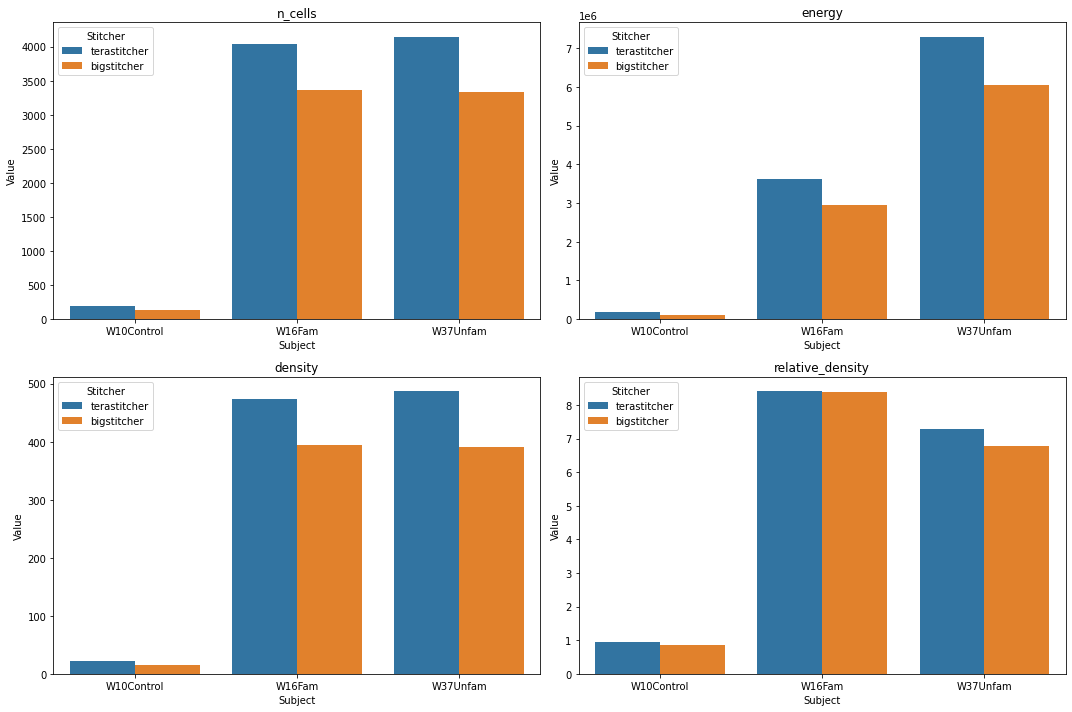

In [191]:
plot_differences(df=make_df(dictionary=dict_results_across_mice, area='Main olfactory bulb'))

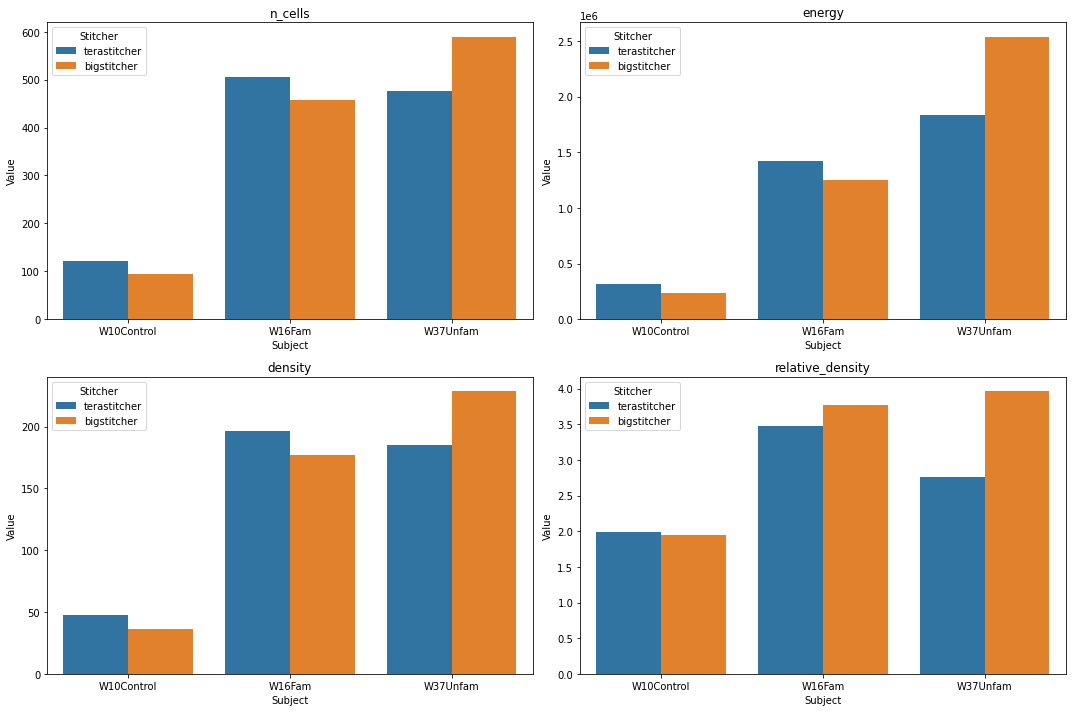

In [193]:
plot_differences(df=make_df(dictionary=dict_results_across_mice, area='Anterior olfactory nucleus'))

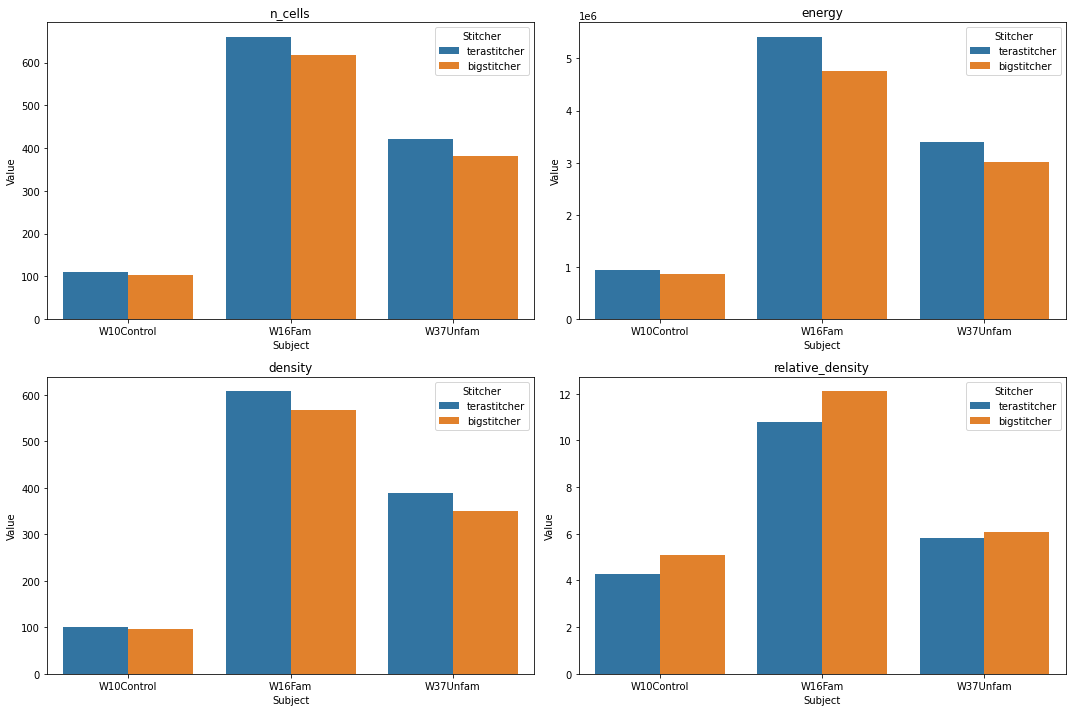

In [194]:
plot_differences(df=make_df(dictionary=dict_results_across_mice, area='Medial amygdalar nucleus'))

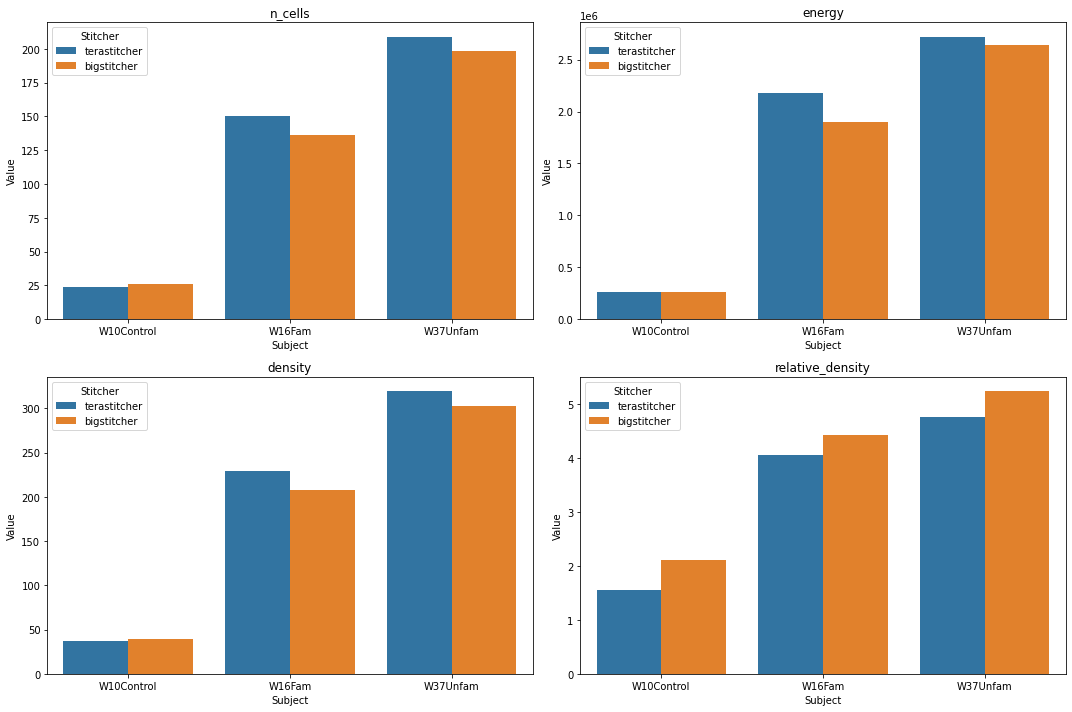

In [196]:
plot_differences(df=make_df(dictionary=dict_results_across_mice, area='Piriform-amygdalar area'))

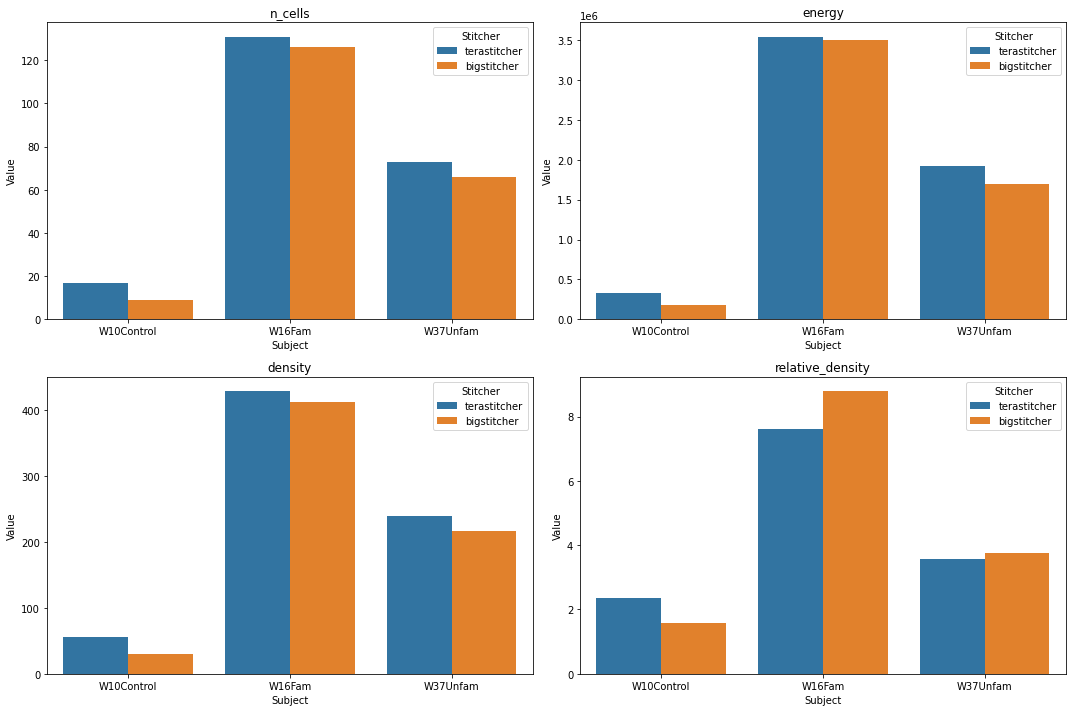

In [198]:
plot_differences(df=make_df(dictionary=dict_results_across_mice, area='Supramammillary nucleus'))

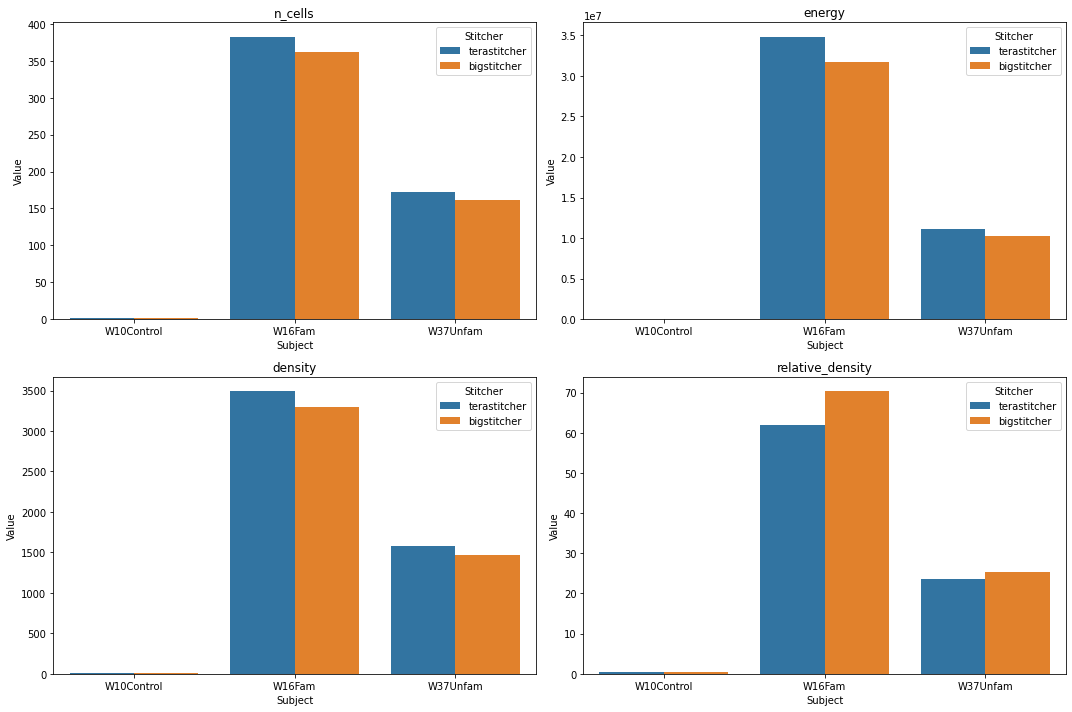

In [199]:
plot_differences(df=make_df(dictionary=dict_results_across_mice, area='Ventral premammillary nucleus'))

# TODO: Heatmap differenze delle aree

# TODO: Confronto mappe di densita' delle aree